# Synthèse des faits pertinents pour l’application

1. Amélioration de la lisibilité du Nutri-Score par ré-étalonnage
    * Entre 0 et 100
    * 0 : mauvais ; 100 : bon


2. **Facteurs principaux** du Nutri-Score :
    * Facteurs négatifs :
        
    * Facteurs positif :
        


3. Nombre de produits pris en charge : **+900'000 produits**
    * Impossibilité de filtrer les produits distribués en France
    * Imputation du Nutri-Score sur la base :
        *      
    * Améliorations possibles :
        * prise en charge de l'EAN8 (8 chiffres, pour les petits emballages)
        * imputation du Nutri-Score :
            * grâce à la formule du Nutri-Score
            * grâce à des algorithmes d'apprentissage automatique


4. Taille de la base de données (**< XX Mo**) :
    * Yuka : 55 Mo + connexion requise
    * Application autonome
    * Transparence pour l'utilisateur des Nutri-Score imputés
    * Améliorations possibles
        * fichier binaire et/ou compressé
        * stocker la note (a-e) plutôt que le score (0-100)


# Import des modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install dython
import dython
sns.set()

## Chargement des données nettoyées

###Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#répertoir avec nos fichiers
images_dir = "/content/drive/My Drive/data/OPC03"

f_open = images_dir + "/data_cleaned.csv"

#Import csv in a DataFrame (10 seconds)
df = pd.read_csv(f_open, low_memory=False)
print ('CSV Imported. Shape :')
data_cleaned = df.copy() #keep a copy of original data


print("Le jeu de données contient {} lignes et {} colonnes.".format(data_cleaned.shape[0],data_cleaned.shape[1])) 
#556324 lignes et 29 colonnes.


CSV Imported. Shape :
Le jeu de données contient 556324 lignes et 29 colonnes.


# Partie 1 - Visualisation par réduction dimensionnelle (t-SNE)

In [0]:
data_cleaned.describe()

,code,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-rescale
count,5.563240e+05,196913.000000,196913.000000,196913.000000,156001.00000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000,556324.000000
mean,4.184127e+12,1.601078,0.048519,0.113365,3.46858,138.749379,13.854692,5.214255,27.411688,14.047997,0.630946,8.753275,1.035802,0.413636,7.642897,58.831096
std,2.194735e+12,2.349546,0.217702,0.403655,0.91917,245.297250,15.393514,7.155528,25.198806,18.431116,2.742394,8.939226,1.997486,0.796730,7.271935,13.221700
min,1.700000e+01,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000
25%,3.250391e+12,0.000000,0.000000,0.000000,3.00000,0.000000,1.860000,0.300000,4.600000,1.000000,0.000000,2.600000,0.100000,0.040000,2.000000,50.909092
50%,3.560071e+12,1.000000,0.000000,0.000000,4.00000,0.000000,12.750000,3.200000,26.000000,7.400000,0.000000,7.817650,0.760000,0.304000,7.000000,60.000000
75%,5.053827e+12,2.000000,0.000000,0.000000,4.00000,192.000000,18.400000,5.600000,46.000000,15.509485,0.000000,10.700000,1.101698,0.440000,12.000000,69.090910
max,9.999999e+12,30.000000,3.000000,5.000000,4.00000,900.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,86.360000,27.600000,40.000000,100.000000


### Encodage de la variable 'nutrition_grade_fr' (variable catégorielle ordinale)
Nous encodons ces données afin de pouvoir afficher des étiquettes colorées avec la t-SNE.

In [0]:
feature = 'nutrition_grade_fr'

# Create mapper
scale_mapper = {"a":5,
                "b":4,
                "c":3,
                "d":2,
                "e":1,
               }

# Replace feature values with scale
data_cleaned['nutrition_grade_fr_encoded'] = data_cleaned[feature].replace(scale_mapper)

### Selection des variables pour la t-SNE

In [0]:
# Selecting all the numeric columns
subset = list(data_cleaned.select_dtypes(include=['number']).columns)

# Adding the 'nutrition_grade_fr' feature (that will be used as label)
subset.append('nutrition_grade_fr')

# Keeping only the required columns in the dataframe
X = data_cleaned[subset]

# Dropping rows with missing values (not handled by t-SNE implementation)
X = X.dropna(subset=subset)

# Dropping an outlier by position
outlier_index = 3761
X = X.drop(X.index[outlier_index])

# Defining the labels
y = X[['nutrition_grade_fr', 'nutrition_grade_fr_encoded']]

### Pré-traitement

In [0]:
# Centering and reducting (except last column: 'nutrition_grade_fr')
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler().fit(X.iloc[:,:-2])
X_std = std_scaler.transform(X.iloc[:,:-2])

### Exécution de la t-SNE

In [0]:
# Import libraries
from sklearn import manifold

# Instanciation of t-SNE
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     init='pca', # initialisation by a PCA
                     # random_state=0 # pour la reproductibilité
                    )

# Applying the t-SNE
X_projected = tsne.fit_transform(X_std) 

### Visualisation de la t-SNE en 2D
Nous procédons à une visualisation des données, en fonction de leur note Nutri-Score ('nutrition_grade_fr'), par t-SNE.

IndexingError: ignored

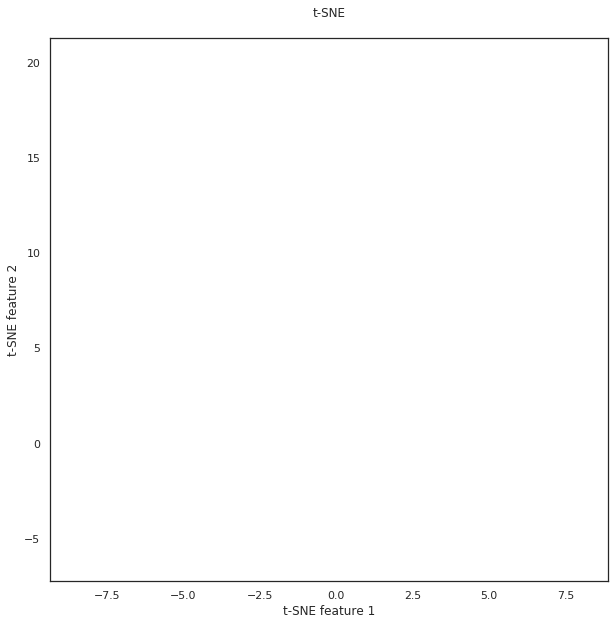

In [0]:
# Graphical representation of the population
plt.figure(figsize=(10,10))

# Definitions of axis boundaries
plt.xlim(X_projected[:,0].min(), X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(), X_projected[:,1].max())

# Definition of axis'labels
plt.title("t-SNE\n")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")

# Glyphes and colors are representing 'Nutri-Score grades'
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], # x-coordinate
             X_projected[:,1][i], # y-coordinate
             y.iloc[i,0], # labels
             color=plt.cm.RdYlGn(int(y.iloc[i,1])/5.)
    )

Nous constatons que, en lisant le graphique de gauche à droite, l'algorithme t-SNE a réussi à saisir la structure des données : les produits sont (globalement) classées par Nutri-Score. De plus, les grappes ("clusters") sont homogènes en terme de score de nutrition.

# Partie 2 - Analyses univariées

## 2.A Variable 'nutrition-score-rescale' (quantitative)
Nous allons étudier en détail la variable 'nutrition-score-rescale' qui va jouer un rôle crucial pour notre application.

### Taux de remplissage

In [0]:
def feature_filling_rate(dataframe, feature):
    """Calculate and displays the filling rate for a particular column in a pd.DataFrame."""
    
    # Count of the values on each column
    values_count = dataframe[feature].count()

    # Calculating filling rates
    nb_rows = dataframe.shape[0]
    filling_rate = values_count / nb_rows

    # Displaying and returning result
    print("The filling rate of the column '{}' is: {:.2%}".format(feature, filling_rate))
    return filling_rate

In [0]:
dataframe = data_cleaned
feature = 'nutrition-score-rescale'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nutrition-score-rescale' is: 100.00%


1.0

### Résumé statistique

In [0]:
data_cleaned['nutrition-score-rescale'].describe()

count    556324.000000
mean         58.831096
std          13.221700
min           0.000000
25%          50.909092
50%          60.000000
75%          69.090910
max         100.000000
Name: nutrition-score-rescale, dtype: float64

Nous en déduisons les principaux indicateurs statistiques pour la variable 'nutrition-score-fr_100g' :
* indicateurs de tendance centrale :
    * moyenne
    * médiane (50ème percentile)


* indicateurs de dispersion :
    * écart-type
    * étendue : max - min
    * intervalle interquartile IQR = Q3 - Q1

### Distribution statistique empirique

In [0]:
def univariate_distribution(dataframe,feature):
    """Function plotting the histogram and boxplot (as subplots) for a distribution."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(20, 10))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(211)
    ax1.set_ylabel("Frequency", fontsize=20)

    # Main graphical properties of the second subplot (boxplot)
    ax2 = plt.subplot(212)
    ax2.set_xlabel("Value", fontsize=20)
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    
    # plotting the plots
    ax1.hist(x, bins=21)
    ax2.boxplot(data_view[feature], showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

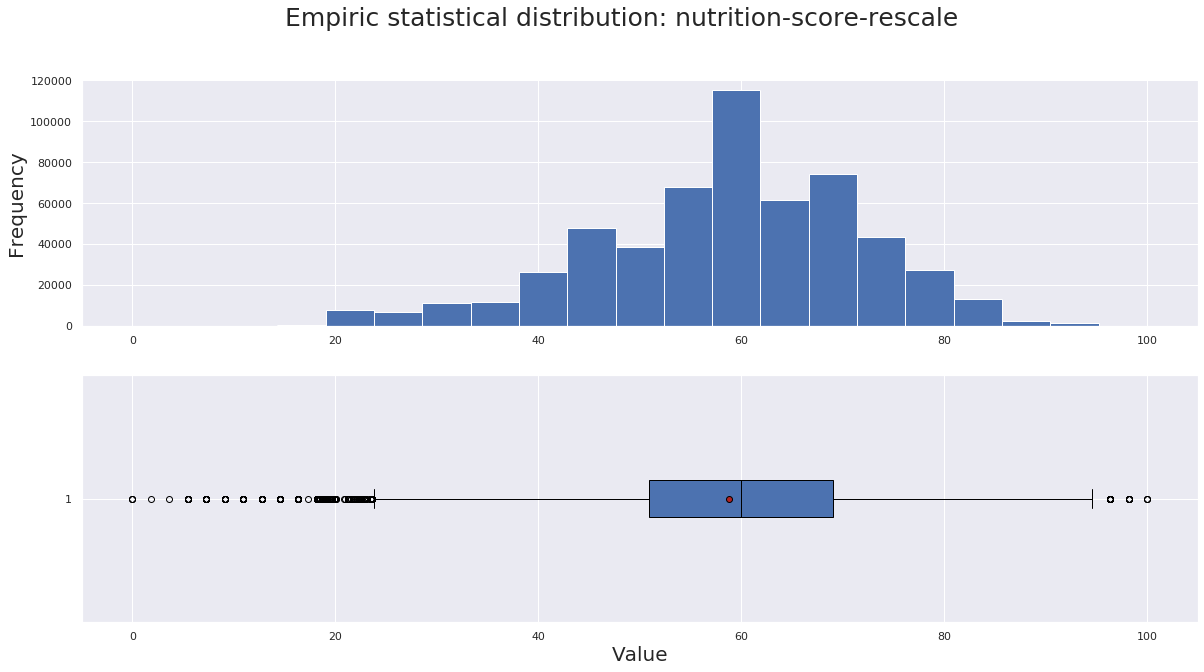

In [0]:
# Plotting the bar chart and box-plot for the statistical distribution
univariate_distribution(data_cleaned,'nutrition-score-rescale')

**Attention :** l'extrémité de la moustache de gauche représente la valeur minimale (min = 0) alors que l'extrémité de la moustache de droite représente la limite des "outliers" (Q3 + 1,5\*IQR). (*whiskers: the vertical lines extending to the most extreme, non-outlier data points.*)

Nous observons une distribution bimodale. En général, une distribution bimodale indique une distribution non-gaussienne. Nous allons donc effectuer des tests statistiques pour tester cette hypothèse.

### Tests de normalité

Nous allons tester la normalité de la distribution statistique. Voici le test statistique :

    H0 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon sont issus d'une population normalement distribuée.

    H1 :  les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon NE sont PAS issus d'une population normalement distribuée

### Test de Shapiro-Wilk

In [0]:
from scipy.stats import shapiro

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-rescale'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-rescale']

# processing the Shopiro-Wilk test
shapiro(data_nutrition_score)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.981332540512085, 0.0)

Nous recevons un avertissement selon lequel la valeur de la p-value n'est peut-être pas correcte en raison de la trop grande taille de l'échantillon. Nous allons donc procéder à un test alternatif : le test d'Anderson-Darling pour la normalité.

### Test d'Anderson-Darling

In [0]:
from scipy.stats import anderson

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-rescale'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-rescale']

# processing the Anderson-Darling test
anderson(data_nutrition_score, dist='norm')

AndersonResult(statistic=3423.513331364258, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

La statistique de test A2 du test d'Anderson-Darling étant plus grande que la valeur critique au niveau de risque 1%, nous pouvons rejeter l'hypothèse nulle (selon laquelle les données proviennent d'une distribution normale) au risque de 1%.

### Test de Kolmogorov-Smirnov

In [0]:
from scipy.stats import kstest

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-rescale'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-rescale']

# performing the Kolmogorov-Smirnov test against normal distribution
kstest(data_nutrition_score, cdf='norm')

KstestResult(statistic=0.9999909878824733, pvalue=0.0)

La p-value du test de Kolmogorov-Smirnov étant proche de 0, nous pouvons rejeter l'hypothèse nulle (selon laquelle les données proviennent d'une distribution normale) avec un risque négligeable de se tromper.

### Test du K2 de D'Agostino

In [0]:
from scipy.stats import normaltest

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-rescale'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-rescale']

# Performing D'Agostino's K2 test
stat, p = normaltest(data_nutrition_score)

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'
    
print(msg)

Sample does not look Gaussian (reject H0)


Tous les tests sont cohérents.

La non-normalité de la distribution de la variables est seulement gènante pour la significativité d'autres tests statistiques qui font l'hypothèse de normalité.

## Etude des valeurs hors-norme (*outliers*) pour le score de nutrition

In [0]:
def select_outliers(dataframe, feature):
    """This function return a view of dataframe with outliers.
    Outliers are those with value less than (Q1 + 1.5*IQR) or bigger than (Q3 + 1.5*IQR)"""
    
    Q1 = dataframe[feature].quantile(q=0.25, interpolation='linear')   # first quartile
    Q3 = dataframe[feature].quantile(q=0.75, interpolation='linear')   # third quartile
    IQR = Q3 - Q1                                                      # inter-quartile range
    
    # definition of mask
    mask = (dataframe[feature] < Q1 - 1.5*IQR) | (dataframe[feature] > Q3 + 1.5*IQR)
    
    # application of mask
    outliers = dataframe[mask]
    
    return outliers

In [0]:
# Selection of outliers (IQR method)
outliers = select_outliers(data_cleaned,'nutrition-score-rescale')

# Increase maximum number of columns to dispaly
pd.set_option("display.max_columns", 1000)

outliers

,code,product_name,quantity,categories_en,labels_en,countries_en,ingredients_text,additives_n,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,imputed_sodium_100g,nutrition-score-rescale,nutrition_grade_fr_encoded
97,125512,Stylo glaçage gris,NaN,Food decorations,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,Unknown,unknown,Food decorations,0.0,38.000000,36.000000,58.000000,58.000000,0.0,3.000000,0.500000,0.200000,29.00,False,20.000000,1
213,20004552,Côtes du Rhône Villages 2014,75 cl e,"Beverages,Alcoholic beverages,Wines,Wines from...","Not advised for specific people,PDO,Made in Fr...",France,"Vin rouge, sec. Contient des _sulfites_.",0.0,NaN,NaN,0.0,0.0,e,3.0,NaN,Alcoholic beverages,Beverages,0.0,13.854209,5.381147,27.388647,13.966883,0.0,8.629423,1.026434,0.409883,29.24,False,19.563637,1
256,40144078,M&M's Peanut Butter,46.2 g,"Snacks,Sweet snacks,Confectioneries,Chocolate ...",Contains GMOs,France,"Sucre, _Arachide_, pâte de cacao, lait écrémé ...",2.0,"en:e322,en:e322i,en:e414","E322 - Lecithins,E322i - Lecithin,E414 - Acaci...",0.0,1.0,e,4.0,Sugary snacks,Sweets,Snacks,0.0,30.500000,18.800000,51.600000,51.600000,0.0,0.000000,2.230000,0.892000,36.00,False,7.272727,1
526,2000005429,Lindt,NaN,fr:tablettes-chocolat-noir,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,Unknown,unknown,fr:tablettes-chocolat-noir,0.0,55.000000,30.000000,14.000000,7.000000,0.0,10.000000,3.000000,1.200000,28.00,False,21.818182,1
583,3004032145,Chinois Nature Décongelé,600 g,"Snacks,Sweet snacks,Viennoiseries,Brioches,fr:...",Unfrozen,France,"Farine de BLÉ , garniture pâtissière 25 % ( ea...",12.0,"en:e14xx,en:e170,en:e263,en:e322,en:e330,en:e3...","E14XX - Modified Starch,E170 - Calcium carbona...",1.0,4.0,e,4.0,Sugary snacks,pastries,Snacks,0.0,36.000000,36.000000,18.000000,18.000000,0.0,20.000000,3.000000,1.200000,27.00,False,23.636364,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556298,3436290002047,Baron d'Albénas 2010,75cl,"Beverages,Alcoholic beverages,Wines,Wines from...",PGI,France,"Raisins blancs, Cépage : Muscat sec",0.0,NaN,NaN,0.0,0.0,e,3.0,NaN,Alcoholic beverages,Beverages,0.0,13.854209,5.381147,27.388647,13.966883,0.0,8.629423,1.026434,0.409883,29.24,False,19.563637,1
556307,3760009532427,bière blonde houblonnée,33cl,"Beverages,Alcoholic beverages,Beers,Lagers,fr:...","Organic,EU Organic,fr:ab-agriculture-biologique",France,"Eau, malts d'orge, sucre de canne, houblons",0.0,NaN,NaN,0.0,0.0,e,3.0,NaN,Alcoholic beverages,Beverages,0.0,13.854209,5.381147,27.388647,13.966883,0.0,8.629423,1.026434,0.409883,29.24,False,19.563637,1
556309,3760031905053,Cidre Rosé (3%),75 cl,"Beverages,Alcoholic beverages,Artisan products...","Not advised for specific people,Green Dot,Not ...",France,"Pur jus de pommes à cidre, colorant. Contient ...",0.0,NaN,NaN,0.0,0.0,e,4.0,NaN,Alcoholic beverages,Beverages,0.0,13.854209,5.381147,27.388647,13.966883,0.0,8.629423,1.026434,0.409883,29.24,False,19.563637,1
556313,3760204756154,Le Héron,750 ML,"Beverages,Alcoholic beverages,Wines,fr:Vins mo...",NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,NaN,Alcoholic beverages,Beverages,0.0,13.854209,5.381147,27.388647,13.966883,0.0,8.629423,1.026434,0.409883,29.24,False,19.563637,1


Nous obtenons quelques valeurs "hors-normes" (*ouliers*). Celles-ci correspondent à des valeurs très élevées de la variable "score de nutrition". Nous constatons que  la plupart des données pour ces lignes sont des alcools ou des sucreries ce qui effectivement un type d'aliment atypiques. 

## 2.B Variable 'nova_group' (variable catégorielle ordinale)

In [0]:
dataframe = data_cleaned
feature = 'nova_group'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nova_group' is: 28.04%


0.28041393145001836

In [0]:
# Converting to integer, allowing Nan values with "I"nt
data_cleaned['nova_group'] = data_cleaned['nova_group'].astype('Int64', errors='ignore')

# Converting the dtype as ordinal categorical feature
from pandas.api.types import CategoricalDtype
data_cleaned['nova_group'] = data_cleaned['nova_group'].astype(CategoricalDtype(ordered=True))

In [0]:
data_cleaned['nova_group'].describe()

count     156001
unique         4
top            4
freq      105163
Name: nova_group, dtype: int64

In [0]:
def categorical_distribution(dataframe,feature):
    """Function plotting the bar-plot and pie-plot (as subplots) for 
    a distribution of categorical features."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Set frequencies and labels
    labels = list(x.value_counts().sort_index().index.astype(str))
    frequencies = x.value_counts().sort_index()
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel("Values", fontsize=20)
    ax1.set_ylabel("Frequencies", fontsize=20)

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Relative frequencies", fontsize=20)
    
    # plotting the plots
    ax1.bar(labels, frequencies)
    ax2.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True,
              )
    
    ax2.legend(labels)
    plt.show()

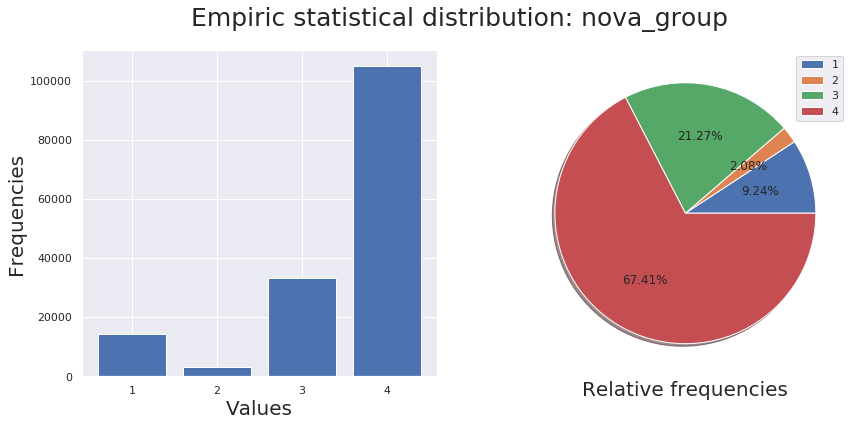

In [0]:
dataframe = data_cleaned
feature = 'nova_group'

categorical_distribution(dataframe,feature)

# Partie 3 - Analyses bivariées
**NB :** par "analyse bivariée", nous entendons une étude détaillée des interactions entre deux variables.

L'étude globale des corrélations entre variables sera traitée dans la partie 4 : analyses multivariées.

## 3.1 Analyse bivariée : 'nutrition_grade_fr' vs 'nutrition-score-rescale'
nutrition_grade_fr : nutrition grade ('a' to 'e'). see http://fr.openfoodfacts.org/score-nutritionnel-experimental-france

In [0]:
def modal_boxplots(dataframe, modal_feature, numerical_feature):
    '''This function return a plot of boxplots for each modality.
    Useful for bivariate analysis.'''
    
    # Creating a copy of the two features
    data_sample = dataframe[[modal_feature, numerical_feature]].copy()

    # Drop the rows where values are missing for the two features
    data_sample = data_sample.dropna(subset=[modal_feature, numerical_feature])

    # Getting the list of modalities
    modalities = data_sample[modal_feature].sort_values().unique()
    groups = []

    # Iteration on each modality
    for modality in modalities:
        # Keep only the numerical_feature for the rows (kind of a groupby)
        groups.append(data_sample[data_sample[modal_feature]==modality][numerical_feature])

    # Graphical properties   
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}

    # Properties of the box-plot
    fig = plt.figure(figsize=(15, 6))
    plt.title(modal_feature + " vs " + numerical_feature, fontsize=20)
    plt.xlabel("Values of " + modal_feature, fontsize=15)
    plt.ylabel("Values of " + numerical_feature, fontsize=15)

    # Plotting the box-plot
    plt.boxplot(groups, labels=modalities, showfliers=False, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

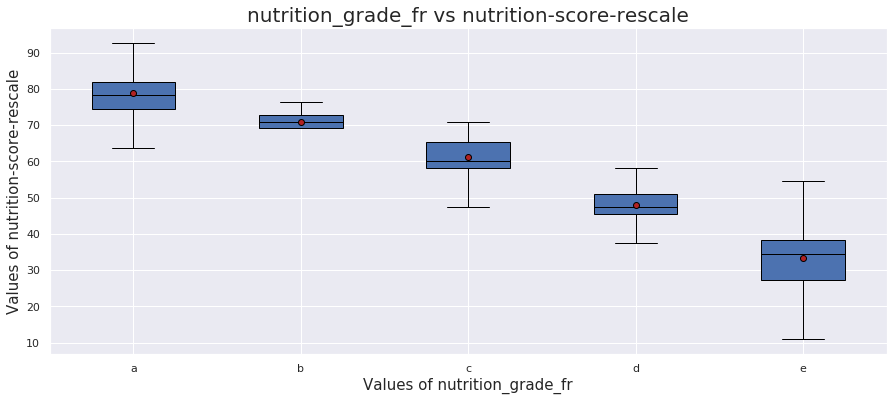

In [0]:
dataframe = data_cleaned
modal_feature = 'nutrition_grade_fr'
numerical_feature = 'nutrition-score-rescale'

modal_boxplots(dataframe, modal_feature, numerical_feature)

Nous pouvons constater qu'il y a quelques anomalies dans l'encodage du Nutri-Score.

Théoriquement, les diagrammes en boîtes devraient être disjoints.
cela veut dire que les variables présente avant mon nétoyage été mal encodé

## 3.2 Analyse bivariée : 'nova_score' vs 'nutrition-score-rescale'

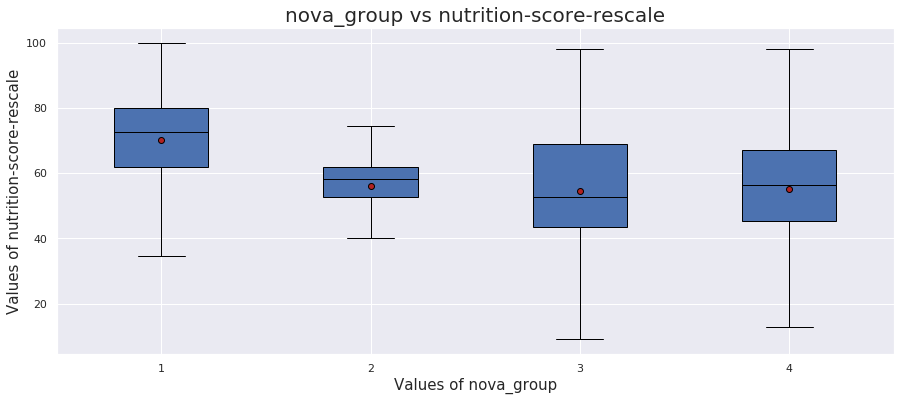

In [0]:
dataframe = data_cleaned
modal_feature = 'nova_group'
numerical_feature = 'nutrition-score-rescale'

modal_boxplots(dataframe, modal_feature, numerical_feature)

### Calcul du coefficient de corrélation linéaire (Pearson)

In [0]:
s1 = data_cleaned['nova_group']
s2 = data_cleaned['nutrition-score-rescale']

print("The Pearson linear correlation coefficient is: r = {}".format(s1.corr(s2, method='pearson')))

The Pearson linear correlation coefficient is: r = -0.2318148966120931


Nous obtenons un coefficient indiquant une corrélation négative entre les deux variables. Pour savoir si cette corrélation est néanmoins significative, nous allons procéder à un test statistique d'indépendance.

### Test d'indépendance du Khi-2

    H0 : les deux variables 'nova_group' et 'nutrition-score-fr_100g' sont indépendantes

    H1 : les deux variables ne sont pas indépendantes

In [0]:
# Constructing the Contingency Table
f_obs = pd.crosstab(data_cleaned['nova_group'], data_cleaned['nutrition-score-rescale'],margins=True)

# The Chi-Squared test for independence
from scipy import stats
results = stats.chi2_contingency(f_obs)
print("χ2 = {}\np-value = {}\ndegrees of freedom = {}".format(results[0], results[1], results[2]))

χ2 = 36727.67003499506
p-value = 0.0
degrees of freedom = 1140


Comme la p-valeur est proche de zéro, nous pouvons rejeter l'hypothèse H0 d'indépendance avec un risque négligeable de nous tromper.

Nous en concluons que les variables 'nova_group' et 'nutrition-score-fr_100g' sont donc dépendantes.

## 3.3 Analyse bivariée : 'additives_n' vs 'nutrition-score-rescale'

### Nuage de points

In [0]:
dataframe = data_cleaned[['additives_n', 'nutrition-score-rescale']].dropna()

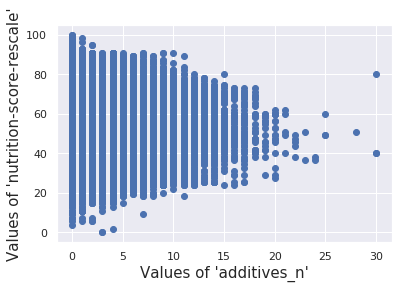

In [0]:
x = dataframe['additives_n']
y = dataframe['nutrition-score-rescale']

plt.xlabel("Values of 'additives_n'", fontsize=15)
plt.ylabel("Values of 'nutrition-score-rescale'", fontsize=15)

plt.scatter(x, y)

### Calcul du coefficient de corrélation linéaire (Pearson)

In [0]:
s1 = data_cleaned['additives_n']
s2 = data_cleaned['nutrition-score-rescale']

print("The Pearson linear correlation coefficient is: r = {}".format(s1.corr(s2, method='pearson')))

The Pearson linear correlation coefficient is: r = -0.15043426263505666


Nous obtenons un coefficient indiquant une corrélation négative entre les deux variables.

# Partie 4 - Analyses multivariées

## 4.1 Corrélations bivariées avec pairplot de seaborn

### Échantillonnage
Pour éviter les erreurs d'insuffisance mémoire, nous échantillonnons le jeu de données.

In [0]:
# Sampling (1 out of 1'000)
data_sample = data_cleaned.sample(frac=0.001)

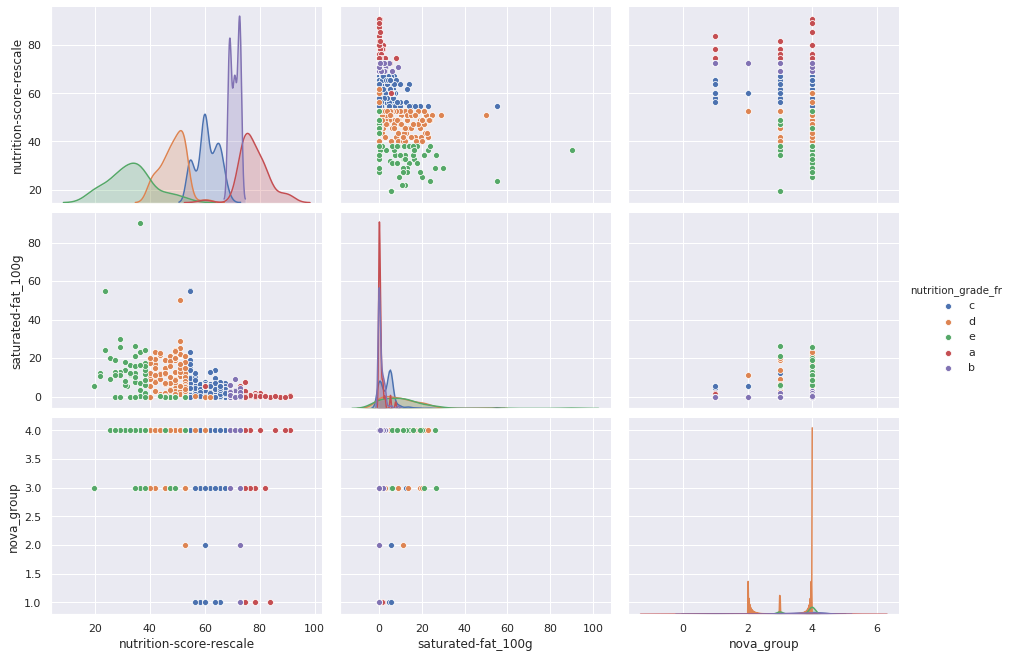

In [0]:
# Selecting some features for plotting
features = ['nutrition-score-rescale', 'saturated-fat_100g', 'nova_group', 'nutrition_grade_fr']
data_sample = data_sample[features]

# Selecting numeric features only
# data_sample = data_sample.select_dtypes(include='number')

# Plotting pairwise relationships in the dataset (numeric features)
sns.pairplot(data_sample, hue='nutrition_grade_fr', height=3, aspect=1.4)

## 4.2 Matrice de corrélation pour les variables quantitatives

In [0]:
def correlation_matrix(dataframe):
    """This function plots a correlation matrix using the seaborn package."""

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    plt.title("Correlation matrix", fontsize=25)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

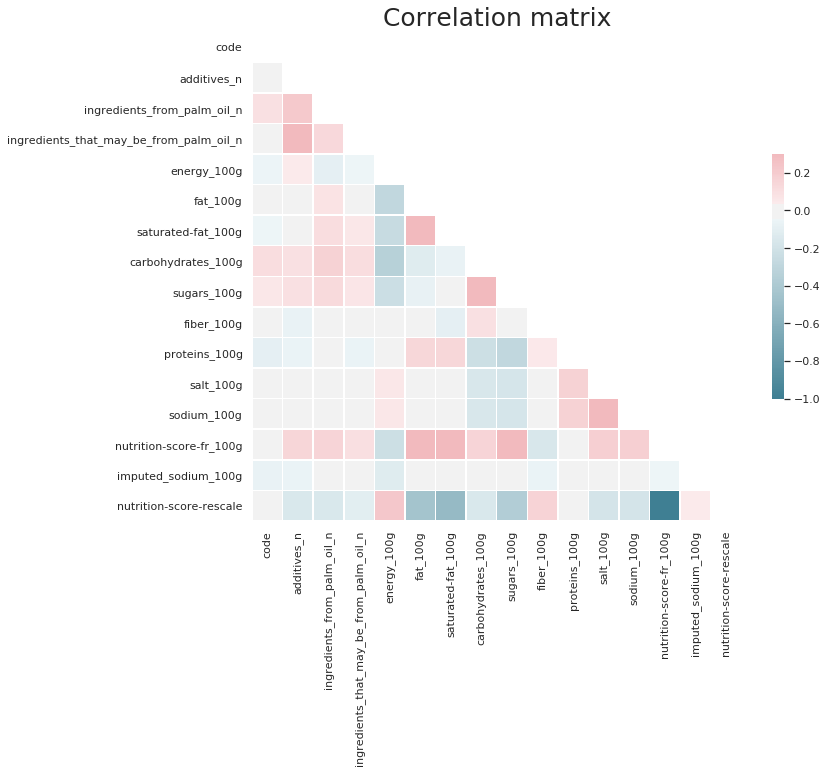

In [0]:
# filtering features to avoid to crunch the representation
dataframe = data_cleaned.drop(columns=['nutrition_grade_fr_encoded'])

correlation_matrix(dataframe)

## 4.3 Vecteur de corrélation pour la variable 'nutrition-score-rescale'
Comme nous nous intéresssons spécifiquement aux corrélations de la variable de 'nutrition-score-fr_100g', nous allons projeter la matrice de corrélations sur cette seule variable afin d'obtenir un "vecteur de corrélation".

In [0]:
def correlation_vector(dataframe, feature):
    """This functions plots a correlation vector for a single feature."""

    # Load libraries
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Compute the correlation matrix
    corr_matrix = dataframe.corr()

    # Keep only vector related to feature (pd.Series)
    corr_vector = corr_matrix[feature]
    
    # Remove the self-correlation case
    corr_vector = corr_vector.drop(feature)
    
    # Sort the pd.Series by descending order
    corr_vector = corr_vector.sort_values(ascending=False)

    # Convert the pd.Series to pd.DataFrame to fit requirements for sns.heatmap
    corr_vector = pd.DataFrame(corr_vector)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(3, 10))
    plt.title("Correlation vector\n" + feature + "\n", fontsize=25)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_vector, cmap=cmap, vmax=.3, center=0,
                square=False, linewidths=0.5, cbar_kws={"shrink": .5}, annot=True, fmt='1.3f', cbar=False)

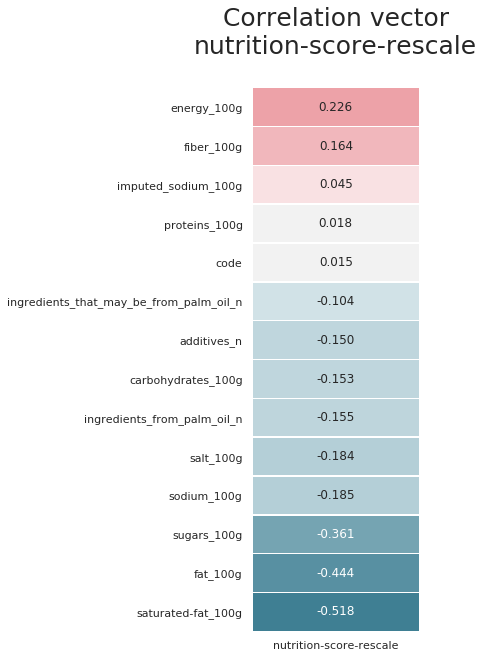

In [0]:
# filtering features to avoid to crunch the representation
dataframe = data_cleaned.drop(columns=['nutrition_grade_fr_encoded', 'nutrition-score-fr_100g'])
feature = 'nutrition-score-rescale'
correlation_vector(dataframe, feature)

En analysant ce vecteur de corrélation, nous pouvons constater que le score de nutrition rééchelonné ('nutrition-score-fr_100g') est positivement corrélé à :
* la présence de fibres
* l'energy pour100g

Et négativement corrélé avec :
* la présence de graisses saturées
* la présence d'huile de palme
* la présence d'additifs
* la présence de sucres
* le niveau de transformation du produit ('nova_group')

Cela est cohérent avec le fait qu'un aliment est d'autant meilleur pour la santé que son score de nutrition est bas.

## 4.4 Correlations intégrant les variables catégorielles (dython)
La librairie dython (http://shakedzy.xyz/dython/) permet de calculer :
* pour les couples de variables quantitatives :
    * le coefficient de correlation de Pearson R 
    
    
* pour les couples de variables catégorielles :
    * le coefficient de Cramer V (symetrique)
    * le coefficient d'incertitude de Theil U (asymetrique)
    
    
* pour les couples de variables mixtes (quantitative + catégorielle) :
    * le ratio de correlation η (eta)

one not encoding 
sckit learn one not encoder
pandas get dummys 
rend les calcules plus lourd

binnary encoder 
sckit learn 
variable manquante sur les categories 


In [0]:
"""from dython.nominal import associations

nominal_columns = ['nova_group', 'nutrition_grade_fr', 'main_category']

# Have to drop NaN values to avoid errors
df_for_correlations = data_cleaned[['nova_group', 'nutrition_grade_fr', 'main_category', 'nutrition-score-rescale']].dropna()

# Calculate associations and display graph
associations(
    df_for_correlations,
    figsize=(15,5),
    theil_u=True, # asymetric measure of correlation for nominal feature
    nominal_columns=nominal_columns"""
)

SyntaxError: ignored

In [0]:
dataframe = data_cleaned
feature = 'nutrition-score-rescale'
feature_filling_rate(dataframe, feature)

In [0]:
data_cleaned.select_dtypes(include= np.number).columns

In [0]:
columns_x= ['energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g',
       'nutrition-score-uk_100g', 'nutrition_grade_fr_encoded']

X = data_cleaned[columns_x].values
y = data_cleaned['nutrition-score-rescale'].values

fig = plt.figure(figsize=(32, 24))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(6,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data_cleaned.columns[feat_idx], fontsize=14)


Nous constatons que la variable 'nutrition-score-fr_100g' est très corrélée aux variables :



# Sauvegarde des données pour l'application
Nous ne conservons que les produits :
* dont le code barre et le nom de produit sont renseignés
* dont le score de nutrition est renseigné ou a pu être imputé
* commercialisés en France

####sauvegarde

In [0]:
# Save as .csv file
data_cleaned.to_csv("p3_finaldata.csv")

# Print the size of the final database
import os
print("The size of the final database is: {} bytes.".format(os.path.getsize('p3_finaldata.csv')))

#Constante nutritionelle

##Calcule apport calorique
formule de Black 
    hommes : 259 * ( P^0.48 * T ^ 0.5 * A ^ -0.13)
    femmes : M B = 230 ⋅( P^0.48 * T ^ 0.5 * A ^ -0.13)

Besoins caloriques quotidiens moyens estimés en fonction de l'activité
(pour un MB de 1650 kcal environ) activité 	Mode de calcul 	Kilocalories
Homme et femme sédentaires 	Métabolisme de base x 1,37 	2261
Homme et femme actifs 	Métabolisme de base x 1,55 	2558
Homme et femme sportifs 	Métabolisme de base x 1,80 (voire x 2) 	2971 

https://fr.wikipedia.org/wiki/M%C3%A9tabolisme_de_base

In [0]:
#création de profil 
Nom = "Paul"
Age = 23
Taille = 1.85
Poid = 85
Sexe = "homme"
#metabolisme de base
MB = 259*( (Poid **(0.48)) * (Taille **(0.5)) * (Age **-(0.13))) 
print(MB)

In [0]:
#Activité
MB = MB *1.55
print(MB)

##Tableau ANC
Besoin journalier

https://secure-ecsd.elsevier.com/fr/Ban_Produits/Schlienger/Extrait-schlienger.pdf

http://www.sante-et-nutrition.com/recommandations-nutritionnelles-anses/


In [0]:

#Groupe generique
data_gr = {'score': ["Fruit et légumes","Féculents", "Légumineuses", "Viandes et Charcuterie, produits de la pêche, oeufs", "Lait et produits laitiers", "Matieres grasses ajoutées", "Produits sucré", "Eau", "Boissons sucrées", "Sel"], 
        'tags': [['df_fruits'],['df_féculents'],['Lentilles', 'pois chiches', 'feves'],['df_meat'],['df_milk'],['df_fat'],['df_sugar'],['water'],['df_drinks'],['salt']]}
df_gr = pd.DataFrame(data_gr, columns = ['score', 'tags'])

#Sous-Groupe et aliments
#Fruit et légumes
data_fruits = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_fruits = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Féculents
data_féculents = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_féculents = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Viandes et Charcuterie, produits de la pêche, oeufs
data_meat = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_meat = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Lait et produits laitiers
data_milk = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_milk = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Matieres grasses ajoutées
data_fat = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_fat = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Produits sucré
data_sugar = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_sugar = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

#Boissons sucrées
data_drinks = {'Groups': ["Fruit frais", "Fruit secs","Fruit transformés","Légumes","Oléagineux" ], 
        'Examples': [['Pommes','bananes','oranges'],['Abricots secs','pruneaux'],['Compotes','fruits au sirop'],['Courgettes', 'carottes', 'tomates', 'haricot',],['Oléagineux']]}
df_drinks = pd.DataFrame(data_fruit, columns = ['Groups', 'Examples'])

# view the dataset
print(df_gr)
print('/n')
print(df_fruits)
print('/n')
print(df_féculents)
print('/n')
print( df_meat)
print('/n')
print(df_milk)
print('/n')
print(df_fat)
print('/n')
print(df_sugar)
print('/n')
print(df_drinks )

In [0]:
#Vitamines(en mg et B9, B12, A, D en μg)
ar = np.array([[1.5, 1.8, 17.4 , 14, 1.8, 330, 3.4, 110, 800, 5, 12], [1.1, 1.5, 14, 11, 1.5, 300, 2.4, 110, 600, 5, 12], [1.8, 1.6, 0,16, 2, 400, 2.6, 120, 700, 10, 12], [1.2, 1.6, 0, 14, 2.2, 350, 3.0, 120, 700, 12, 35]])
df_vit = pd.DataFrame(ar, index = ['Hommes adultes', 'Femmes adultes', 'Femmes enceintes', 'Personnes âgées'], columns = ["B1", "B2","B3", "PP","B6","B9","B12","C","A","D","E"])

# Minéraux et oligoéléments(en mg. I et SE en μg)
ar = np.array([[900, 750, 420, 9,12,150, 60, 1.3], [900, 750,360, 16, 10, 150, 50, 1 ], [1000, 800, 400, 30, 14, 200, 60, 0], [1200, 800,400, 10, 12, 150, 80, 0]])
df_min = pd.DataFrame(ar, index = ['Hommes adultes', 'Femmes adultes', 'Femmes enceintes', 'Personnes âgées'], columns = ["Ca","P","Mg","Fe","Zu","I","Se", "Cu"])

print(df_vit)
print(df_min)

In [0]:
# Ratio(lim min et max)
Protéines(%AET) = [10, 20]
Lipides(%AET) = [35, 40]
Glucides(%AET) = [40, 55]

#apport max
Acide_gras_saturés(%AET) = 12
Acide_lauriques+myristique+palmitique(%AET)= 8
Sucres(g) = 50

#apport satisfesant
Acide linéoléique(%AET) = 4
Acide_alpha-linéoléique(%AET) = 1
EPA+DHA(mg) = 500
Fibres(g) = 30
ar = np.array([[900, 750, 420, 9,12,150, 60, 1.3], [900, 750,360, 16, 10, 150, 50, 1 ], [1000, 800, 400, 30, 14, 200, 60, 0], [1200, 800,400, 10, 12, 150, 80, 0]])
df_min = pd.DataFrame(ar, index = ['Protéines(%AET)', 'Lipides(%AET)', 'Glucides(%AET)', 'Personnes âgées'], columns = ["Ca","P","Mg","Fe","Zu","I","Se", "Cu"])


Au vue de ces contraintes, nous pouvons suprimer les produit eyant un profil trop desiquilibré ext ..